# CO2 Emissions Analysis and Prediction Model

This notebook is organized into the following sections:
1. Imports & Settings  
2. Utility Functions  
3. Data Loading  
4. Preprocessing  
5. Exploratory Data Analysis  
6. Clustering Analysis  
7. Feature Selection  
8. Model Training & Evaluation with Hyperparameter Tuning  
9. Main Execution

In [12]:
# ====================
# 1. IMPORTS & SETTINGS
# ====================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import describe, uniform, randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    roc_auc_score
)

# limit threads for reproducibility
os.environ["OMP_NUM_THREADS"] = "1"

## 2. Utility Functions  
Helper functions for statistics, plotting, and evaluation.

In [13]:
def print_distribution_stats(data: pd.Series, name: str):
    """Print basic stats and an ASCII histogram for a numeric feature."""
    stats = describe(data.values)
    q = np.percentile(data, [25, 50, 75])
    print(f"\n--- {name} ---")
    print(f"Count: {stats.nobs}, Mean: {stats.mean:.2f}, Median: {q[1]:.2f}")
    print(f"Std: {np.sqrt(stats.variance):.2f}, Min: {stats.minmax[0]:.2f}, Max: {stats.minmax[1]:.2f}")
    print(f"25th/50th/75th: {q.round(2).tolist()}")
    print(f"Skewness: {stats.skewness:.2f}, Kurtosis: {stats.kurtosis:.2f}")
    hist, _ = np.histogram(data, bins=10)
    mx = hist.max()
    for count in hist:
        bar = '█' * int((count/mx)*20)
        print(f"{bar:20s} | {count}")
    print()


def evaluate_classifier(model, X_test, y_test, name: str):
    """Print metrics, confusion matrix, and ROC (if binary)."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n*** {name} ***")
    print(f"Accuracy: {acc:.3f}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC curve (binary only)
    if len(np.unique(y_test)) == 2:
        probs = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
        plt.plot([0,1],[0,1],'k--')
        plt.title(f"{name} ROC Curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend()
        plt.show()

## 3. Data Loading  

In [14]:
def load_data(path: str) -> pd.DataFrame:
    """Load CSV and encode categorical fields."""
    df = pd.read_csv(path)
    df['Industry_Type_Encoded'] = LabelEncoder().fit_transform(df['Industry_Type'])
    df['Continent_Encoded']    = LabelEncoder().fit_transform(df['Continent'])
    return df

## 4. Preprocessing  

In [15]:
def preprocess(df: pd.DataFrame, features: list):
    """Scale features and split into train/test."""
    X = df[features].values
    y = df['Continent_Encoded'].values
    X_scaled = StandardScaler().fit_transform(X)
    return train_test_split(
        X_scaled, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

## 5. Exploratory Data Analysis  

In [16]:
def exploratory_analysis(df: pd.DataFrame, features: list):
    """Print distribution stats and top correlations."""
    print("\n=== EDA: Distribution Statistics ===")
    for f in features:
        print_distribution_stats(df[f], f)
    corr = df[features].corr().abs()
    pairs = (
        corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
    print("Top 5 feature correlations:\n", pairs.head(5), "\n")

## 6. Clustering Analysis  

In [17]:
def cluster_analysis(X_scaled: np.ndarray):
    """K-Means clustering metrics and PCA scatter."""
    print("\n=== K-Means Clustering Metrics ===")
    km = KMeans(n_clusters=2, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    print(f"Silhouette: {silhouette_score(X_scaled, labels):.3f}")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(X_scaled, labels):.3f}")
    print(f"Davies-Bouldin: {davies_bouldin_score(X_scaled, labels):.3f}\n")
    pca_proj = PCA(n_components=2).fit_transform(X_scaled)
    plt.scatter(pca_proj[:,0], pca_proj[:,1], c=labels, cmap='viridis', alpha=0.6)
    plt.title("K-Means (PCA Projection)")
    plt.xlabel("PC1"), plt.ylabel("PC2")
    plt.show()

## 7. Feature Selection  

In [18]:
def select_top_features(X_train, y_train, feature_names, top_n=5):
    """Train Decision Tree and return top_n features by importance."""
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    importances = dt.feature_importances_
    idx = np.argsort(importances)[::-1][:top_n]
    top_feats = [feature_names[i] for i in idx]
    top_importances = importances[idx]
    
    # Visualize top features
    plt.figure(figsize=(12, 6))
    plt.bar(top_feats, top_importances)
    plt.xlabel('Features')
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    print(f"Top {top_n} features:", top_feats)
    return top_feats

## 8. Model Training & Evaluation with Hyperparameter Tuning  

In [19]:
def train_and_evaluate_tuned(X_train, X_test, y_train, y_test):
    """Train and evaluate tuned Logistic Regression and Decision Tree."""
    # Logistic Regression tuning
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr_param_dist = {
        'C': uniform(0.01, 10.0),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': [None, 'balanced']
    }
    lr_search = RandomizedSearchCV(
        lr, lr_param_dist,
        n_iter=20, cv=5, random_state=42, n_jobs=-1, verbose=1
    )
    lr_search.fit(X_train, y_train)
    print("\nBest Logistic Regression params:", lr_search.best_params_)
    evaluate_classifier(lr_search.best_estimator_, X_test, y_test, "Tuned Logistic Regression")

    # Decision Tree tuning
    dt = DecisionTreeClassifier(random_state=42)
    dt_param_dist = {
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'criterion': ['gini', 'entropy'],
        'class_weight': [None, 'balanced']
    }
    dt_search = RandomizedSearchCV(
        dt, dt_param_dist,
        n_iter=20, cv=5, random_state=42, n_jobs=-1, verbose=1
    )
    dt_search.fit(X_train, y_train)
    print("\nBest Decision Tree params:", dt_search.best_params_)
    evaluate_classifier(dt_search.best_estimator_, X_test, y_test, "Tuned Decision Tree")

## 9. Main Execution  


=== EDA: Distribution Statistics ===

--- Co2_Emissions_MetricTons ---
Count: 6569, Mean: 151.06, Median: 151.77
Std: 85.89, Min: 0.53, Max: 299.99
25th/50th/75th: [76.8, 151.77, 225.31]
Skewness: -0.01, Kurtosis: -1.20
█████████████████    | 626
██████████████████   | 662
██████████████████   | 657
█████████████████    | 638
██████████████████   | 671
██████████████████   | 645
████████████████████ | 712
██████████████████   | 648
██████████████████   | 669
██████████████████   | 641


--- Energy_Consumption_TWh ---
Count: 6569, Mean: 497.17, Median: 495.42
Std: 287.46, Min: 0.63, Max: 999.88
25th/50th/75th: [245.66, 495.42, 748.35]
Skewness: 0.01, Kurtosis: -1.20
███████████████████  | 673
███████████████████  | 655
███████████████████  | 673
██████████████████   | 638
████████████████████ | 681
███████████████████  | 655
███████████████████  | 651
███████████████████  | 653
███████████████████  | 660
██████████████████   | 630


--- Automobile_Co2_Emissions_MetricTons ---
Count: 65

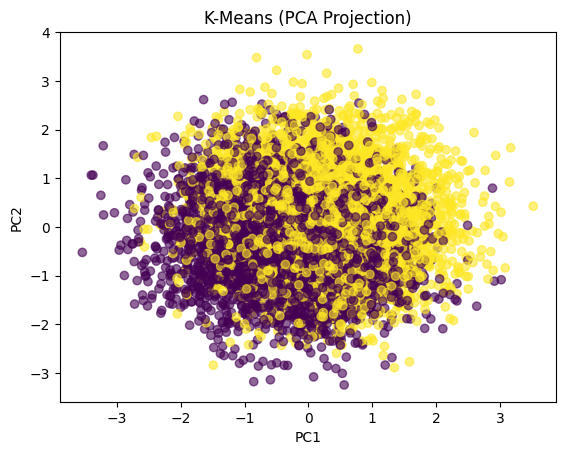

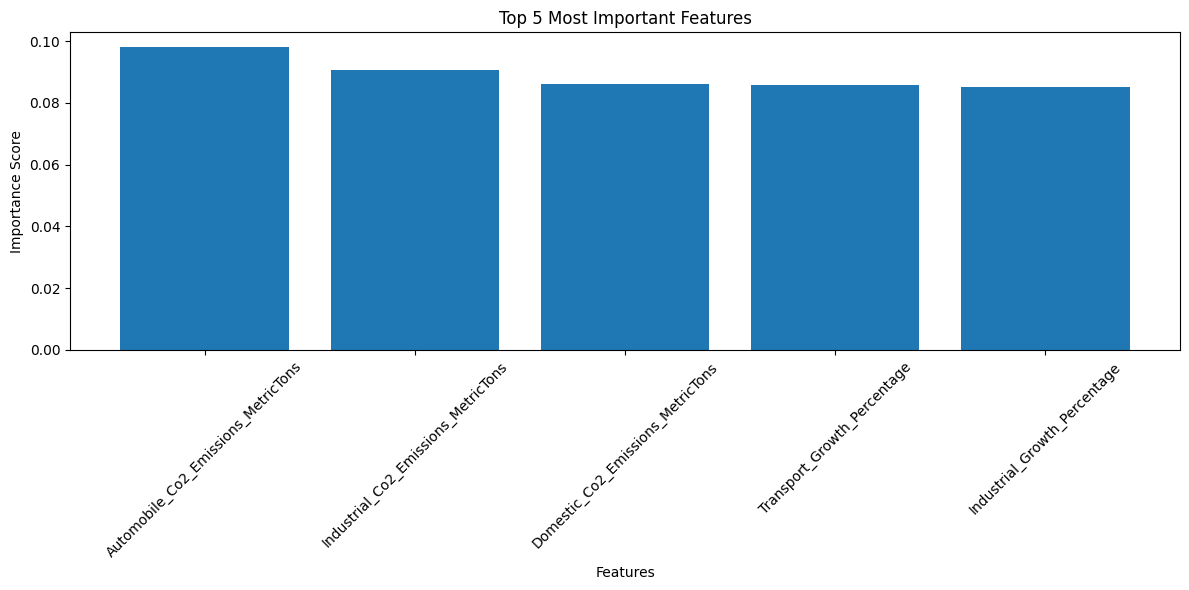

Top 5 features: ['Automobile_Co2_Emissions_MetricTons', 'Industrial_Co2_Emissions_MetricTons', 'Domestic_Co2_Emissions_MetricTons', 'Transport_Growth_Percentage', 'Industrial_Growth_Percentage']
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Logistic Regression params: {'C': 3.7554011884736247, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

*** Tuned Logistic Regression ***
Accuracy: 0.664
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       872
           1       0.00      0.00      0.00       442

    accuracy                           0.66      1314
   macro avg       0.33      0.50      0.40      1314
weighted avg       0.44      0.66      0.53      1314



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


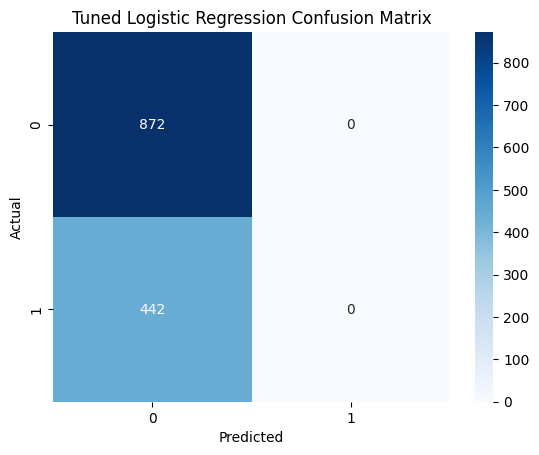

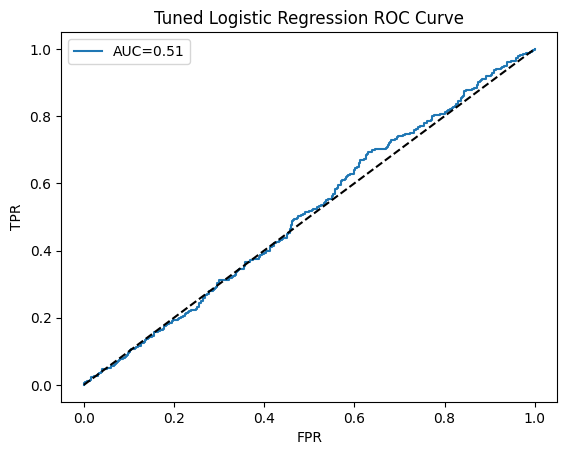

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Decision Tree params: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 12}

*** Tuned Decision Tree ***
Accuracy: 0.664
              precision    recall  f1-score   support

           0       0.66      1.00      0.80       872
           1       0.00      0.00      0.00       442

    accuracy                           0.66      1314
   macro avg       0.33      0.50      0.40      1314
weighted avg       0.44      0.66      0.53      1314



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


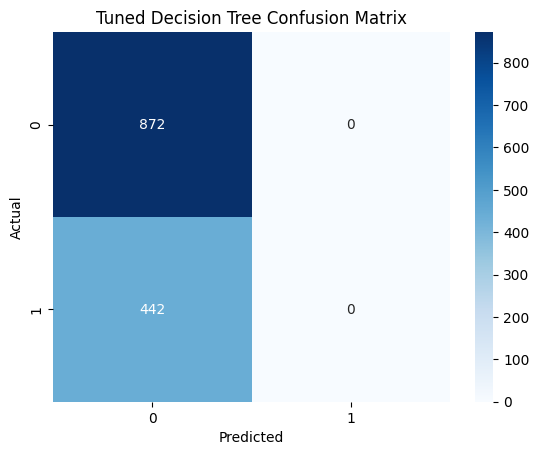

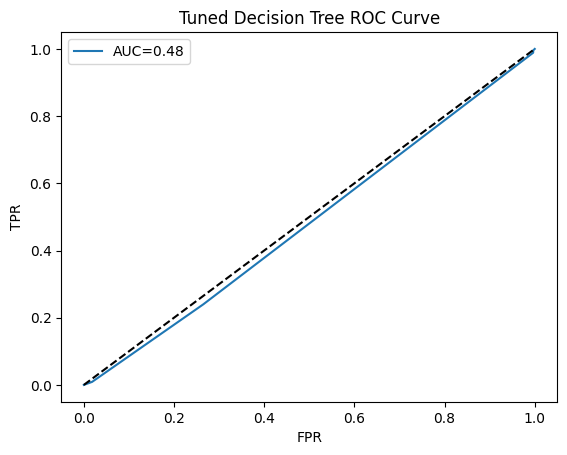


=== Analysis Complete ===


In [20]:
def main():
    # 9.1 Load & Preprocess
    df = load_data('Co2_Emissions_by_Sectors_Europe-Asia.csv')
    features = [
        'Co2_Emissions_MetricTons', 'Energy_Consumption_TWh',
        'Automobile_Co2_Emissions_MetricTons',
        'Industrial_Co2_Emissions_MetricTons',
        'Agriculture_Co2_Emissions_MetricTons',
        'Domestic_Co2_Emissions_MetricTons',
        'Population_Millions', 'GDP_Billion_USD',
        'Urbanization_Percentage', 'Renewable_Energy_Percentage',
        'Industrial_Growth_Percentage', 'Transport_Growth_Percentage',
        'Industry_Type_Encoded'
    ]
    X_train, X_test, y_train, y_test = preprocess(df, features)

    # 9.2 Exploratory Data Analysis
    exploratory_analysis(df, features)

    # 9.3 Clustering (for insight)
    cluster_analysis(np.vstack((X_train, X_test)))

    # 9.4 Feature Selection (Top 5)
    top5 = select_top_features(X_train, y_train, features, top_n=5)

    # 9.5 Retrain & Evaluate using Top 5 with tuning
    X_top = StandardScaler().fit_transform(df[top5].values)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_top, df['Continent_Encoded'].values,
        test_size=0.2, random_state=42, stratify=df['Continent_Encoded']
    )
    train_and_evaluate_tuned(X_tr, X_te, y_tr, y_te)

    print("\n=== Analysis Complete ===")


if __name__ == "__main__":
    main()